In [1]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
#from imblearn.over_sampling import SMOTE


In [2]:
features_df = pd.read_csv('ctd_cadiovascular_20240223_scores.tsv', sep='\t')

ground_truth_df = pd.read_csv('merged_cardio.tsv', sep='\t')

print(features_df.head())
print(ground_truth_df.head())

     drugA    drugB     sAB  opAB  meanspAB  medianspAB  minspAB  maxspAB  \
0  DB06709  DB08506  0.3427     0     0.615       0.630     0.46     0.74   
1  DB06709  DB02376  0.4188     0     0.685       0.685     0.56     0.81   
2  DB06709  DB04282  0.4188     0     0.685       0.685     0.56     0.81   
3  DB06709  DB04564  0.4188     0     0.685       0.685     0.56     0.81   
4  DB06709  DB04659  0.4188     0     0.685       0.685     0.56     0.81   

     zTDA    zTDB  ...  opAD  opBD  meanspAD  meanspBD  medianspAD  \
0  0.5097  1.3545  ...   2.0   0.0    0.5983    0.5773        0.59   
1  0.5097 -1.3890  ...   2.0   0.0    0.5983    0.5969        0.59   
2  0.5097 -1.3890  ...   2.0   0.0    0.5983    0.5969        0.59   
3  0.5097 -1.3890  ...   2.0   0.0    0.5983    0.5969        0.59   
4  0.5097 -1.3890  ...   2.0   0.0    0.5983    0.5969        0.59   

   medianspBD  minspAD  minspBD  maxspAD  maxspBD  
0        0.56      0.0     0.28     1.47     1.30  
1        0.5

In [3]:
merged_df = pd.merge(features_df, ground_truth_df, on=['drugA', 'drugB'])
merged_df.set_index(['drugA', 'drugB'], inplace=True)

X = merged_df.drop(['adv/app','drugcomb','sA','sB','opA','opB'], axis=1)
Y = merged_df['adv/app']
print(X)
print(Y)

                    sAB  opAB  meanspAB  medianspAB  minspAB  maxspAB    zTDA  \
drugA   drugB                                                                   
DB00001 DB00908  0.2497     0    0.5420       0.470     0.42     0.86 -1.0162   
        DB00721  0.3518     0    0.7025       0.605     0.48     1.12 -1.0162   
        DB01109  0.0183     0    0.2867       0.340     0.12     0.40 -1.0162   
        DB00606  0.3436     0    0.5617       0.540     0.40     0.78 -1.0162   
        DB00482  0.2900     0    0.4883       0.495     0.29     0.67 -1.0162   
...                 ...   ...       ...         ...      ...      ...     ...   
DB08899 DB08932  0.1233     0    0.3000       0.300     0.28     0.32 -1.2095   
DB08905 DB08932  0.3833     0    0.5550       0.555     0.55     0.56  0.2120   
DB08918 DB08932  0.1547     0    0.5200       0.520     0.41     0.61 -2.0170   
DB08932 DB08953  0.3467     0    0.5200       0.520     0.51     0.53 -0.2648   
        DB08954  0.0550     

In [4]:
# Splitting the dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [5]:
# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Best k: 4 with average score: 0.9944672131147542


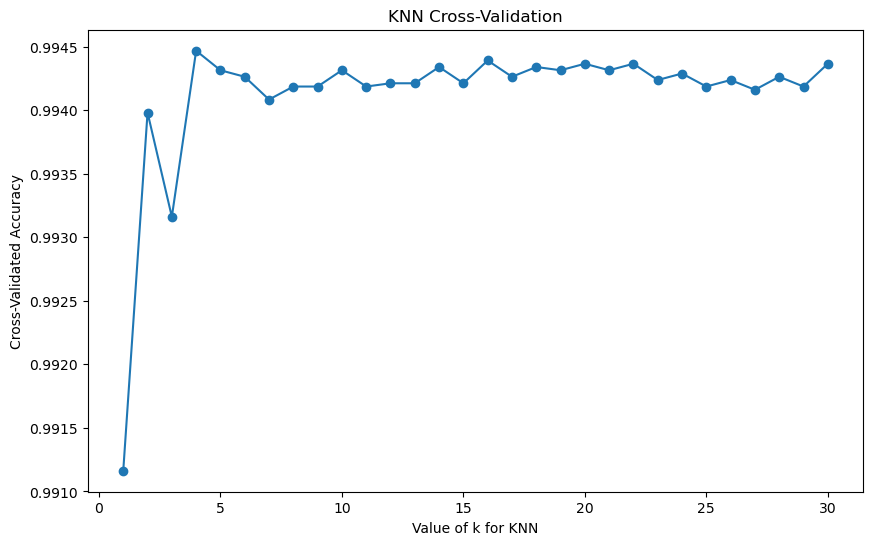

In [6]:
# Assuming X_train_scaled and Y_train are your features and labels, respectively, and are already prepared

# Range of k values to try
k_values = range(1, 31)
k_scores = []

# Perform cross-validation for each value of k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Use cross-validation to evaluate model
    scores = cross_val_score(knn, X_train_scaled, Y_train, cv=10, scoring='accuracy')  # cv=10 for 10-fold cross-validation
    k_scores.append(scores.mean())

# Find the value of k that produces the highest average score
best_k = k_values[np.argmax(k_scores)]
print(f"Best k: {best_k} with average score: {max(k_scores)}")

# Optionally, plot the results to see the trend
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(k_values, k_scores, marker='o')
plt.xlabel('Value of k for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Cross-Validation')
plt.show()


In [30]:
from skopt import BayesSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import ADASYN
from sklearn.metrics import make_scorer, accuracy_score
import pandas as pd

# Annahme: X_train_scaled, X_test_scaled, Y_train und Y_test sind bereits definiert

# Define parameter search space
param_space = {
    'n_neighbors': (1, 20),             # Range for number of neighbors
    'weights': ['uniform', 'distance'], # Choices for weight function
    'p': (1, 2)                         # Range for power parameter for Minkowski distance
}

# Initialize SelectKBest with mutual information as score function to compute feature importance
k_best = SelectKBest(score_func=mutual_info_classif, k=10)  # Select top 10 features based on mutual information

# Fit SelectKBest to the training data to calculate feature importance weights
k_best.fit(X_train_scaled, Y_train)

# Retrieve feature importance scores
feature_weights = k_best.scores_

# Normalize feature weights to sum up to 1
feature_weights /= feature_weights.sum()

# Apply feature weights to the training data
X_train_weighted = X_train_scaled * feature_weights

# Apply feature weights to the test data
X_test_weighted = X_test_scaled * feature_weights

# Initialize ADASYN oversampler
adasyn = ADASYN(random_state=42)

# Apply ADASYN oversampling to training data
X_train_resampled, Y_train_resampled = adasyn.fit_resample(X_train_weighted, Y_train)

# Define custom scorer for accuracy to use with BayesSearchCV
accuracy_scorer = make_scorer(accuracy_score)

# Initialize BayesSearchCV with KNN classifier and parameter search space
knn = BayesSearchCV(
    KNeighborsClassifier(),
    param_space,
    n_iter=20,                # Number of iterations for optimization
    cv=StratifiedKFold(5),    # Cross-validation strategy
    random_state=42,          # Random state for reproducibility
    scoring=accuracy_scorer  # Scoring metric to optimize
)

# Perform Bayesian optimization
knn.fit(X_train_resampled, Y_train_resampled)

# Get best hyperparameters and best score
knn_params = knn.best_params_
best_score = knn.best_score_

print("Best Hyperparameters:", knn_params)
print("Best Accuracy:", best_score)

# Predicting with the KNN model
predictions = knn.predict(X_test_weighted)

# Comparing actual and predicted values
comparison = pd.DataFrame({'Actual': Y_test, 'Predicted': predictions})

# Filtering for mismatches
mask = comparison['Actual'] != comparison['Predicted']
differences = comparison[mask]

print(differences)
print(f"Number of mismatches: {len(differences)}")


# k=6 accuracy : 0.998560411311054
# k=5 accuracy : 0.9989717223650385 (Standard)

Best Hyperparameters: OrderedDict([('n_neighbors', 13), ('p', 1), ('weights', 'distance')])
Best Accuracy: 0.9509748291050576
                 Actual  Predicted
drugA   drugB                     
DB00722 DB01354       1          0
DB00594 DB00606       0          1
DB00252 DB00381       0          1
DB00598 DB02968       0          1
DB00316 DB01115       0          1
...                 ...        ...
DB00204 DB00370       0          1
DB00499 DB00606       0          1
DB00563 DB00627       0          1
DB00350 DB00968       0          1
DB01086 DB01954       0          1

[262 rows x 2 columns]
Number of mismatches: 262


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      9723
           1       0.06      0.38      0.10        37

    accuracy                           0.97      9760
   macro avg       0.53      0.68      0.54      9760
weighted avg       0.99      0.97      0.98      9760



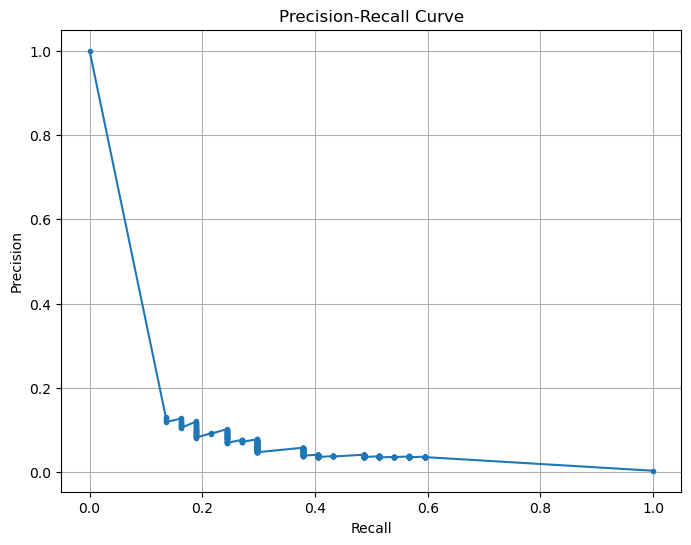

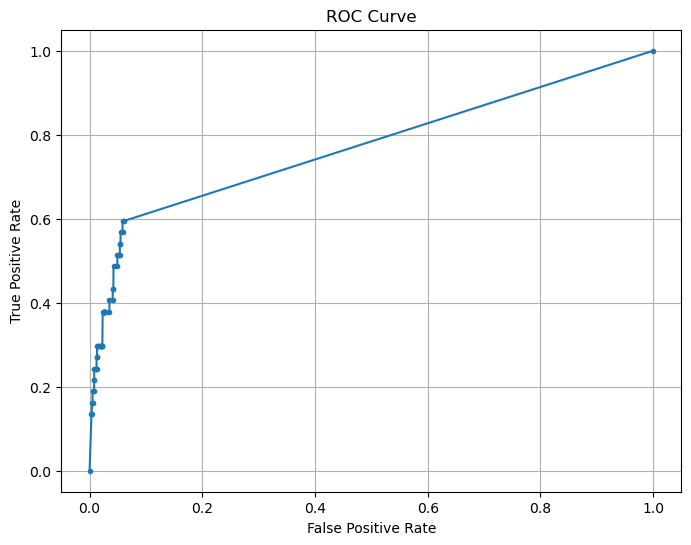

ROC AUC: 0.7713154376221332
Matthews Correlation Coefficient: 0.13682761029957297
Weighted F1 Score: 0.9830021478417078


In [32]:
from sklearn.metrics import classification_report

report = classification_report(Y_test, predictions)
print(report)

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, matthews_corrcoef, f1_score

# Assuming 'clf' is your trained classifier
y_pred_probs = knn.predict_proba(X_test_weighted)[:, 1]  # Predict probabilities for positive class

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(Y_test, y_pred_probs)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(Y_test, y_pred_probs)

# Calculate ROC AUC score
roc_auc = roc_auc_score(Y_test, y_pred_probs)

# Calculate Matthews correlation coefficient
mcc = matthews_corrcoef(Y_test, knn.predict(X_test_weighted))

# Calculate weighted F1 score
weighted_f1 = f1_score(Y_test, knn.predict(X_test_weighted), average='weighted')

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

# Print ROC AUC score
print(f'ROC AUC: {roc_auc}')

# Print Matthews correlation coefficient
print(f'Matthews Correlation Coefficient: {mcc}')

# Print weighted F1 score
print(f'Weighted F1 Score: {weighted_f1}')


In [8]:
''' bayes
ROC AUC: 0.5518414125325573
Matthews Correlation Coefficient: 0.0
Weighted F1 Score: 0.9943171243025657

bayes und selektkbest
ROC AUC: 0.7544190287170849
Matthews Correlation Coefficient: 0.0
Weighted F1 Score: 0.9943171243025657

bayes, selectkBest, ADASYN
ROC AUC: 0.7297547470333647
Matthews Correlation Coefficient: 0.10683071166616323
Weighted F1 Score: 0.9829340231740502
'''